# Driver Behavior Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [3]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [4]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [5]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

Plotting different sensors to see the difference

In [23]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not 'sem_evento'
    highlight_color = 'lightgrey'  # Use the same color for all events

    for i in range(len(data) - 1):
        if data['evento'].iloc[i] != 'sem_evento':
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], 
                        alpha=0.3, color=highlight_color, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()


/tmp/ipykernel_26896/1071966741.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1],


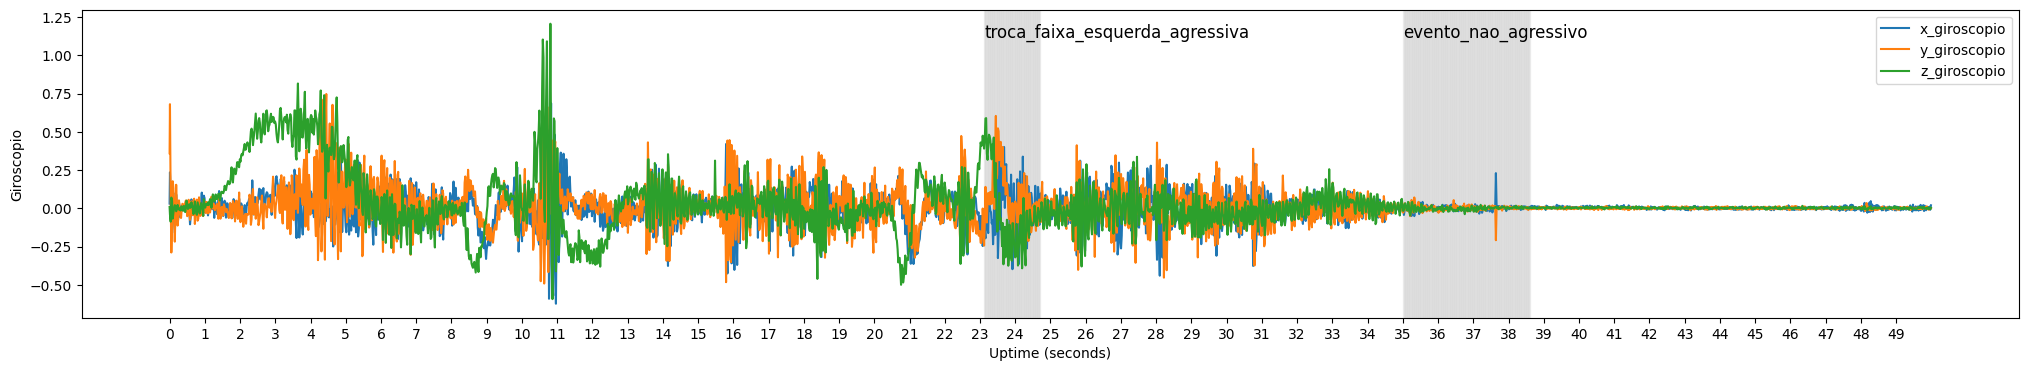

In [24]:
plot_sensor_data(df_21, 'giroscopio', figsize=(25, 4), begin=0, end=50)

In [6]:
data = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(data)):
    data[i] = data[i].drop(cols, axis=1, inplace=False)

# Machine Learning

First, let's try directly applying a RF algorithm using a single drive to see what happens

In [81]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Sliding Windows

In [112]:
teste = df_16[0:3].drop(['timestamp', 'uptimeNanos', 'seconds_passed', 'evento'], axis=1, inplace=False)
features = np.array([])
features = np.append(features, [teste.mean(), teste.max(), teste.min(), teste.std(), teste.max() - teste.min()])
features, len(features)

(array([-1.54335979e-01,  2.55330761e-01, -3.17195127e-01, -1.54335985e-01,
         2.55330782e-01,  9.48945614e+00, -4.08137299e-02,  2.56395433e-03,
         1.30026238e-02, -1.22628438e-01,  3.30180526e-01, -2.09893152e-01,
        -1.22628451e-01,  3.30180484e-01,  9.59675785e+00,  6.62536732e-03,
         9.13043358e-03,  2.96194665e-02, -1.78777061e-01,  1.20173967e-01,
        -3.80996470e-01, -1.78777062e-01,  1.20174074e-01,  9.42565534e+00,
        -7.03716518e-02, -2.28272385e-03, -1.50178816e-02,  2.87709581e-02,
         1.17274857e-01,  9.34789553e-02,  2.87709519e-02,  1.17274781e-01,
         9.34786830e-02,  4.14962355e-02,  5.89773918e-03,  2.44060618e-02,
         5.61486231e-02,  2.10006559e-01,  1.71103318e-01,  5.61486107e-02,
         2.10006410e-01,  1.71102516e-01,  7.69970191e-02,  1.14131574e-02,
         4.46373481e-02]),
 45)

In [9]:
def get_features(window):
    # Features such as mean, max, min and std from the window
    features = np.array([])
    features = np.append(features, [window.mean(), window.max(), window.min(), window.std(), window.max() - window.min()])
    return features

In [10]:
def create_sliding_windows(data, window_size=7, step_size=1):
    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns
            features = get_features(window) # Getting features from the window

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order

            window = np.append(window.to_numpy().flatten(), features) # Flattening the window and appending the features
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [11]:
window_size = 7
step_size = 1
X, y = create_sliding_windows(data, window_size, step_size) # This will create the sliding windows with a 3D X and 1D y
X.shape, y.shape

((10663, 108), (10663,))

Splitting without losing the time property

In [12]:
def split_by_series(X, y, splits_end, proportion):

    splits_begin = [int(splits_end[0] * proportion)] + [int((splits_end[i] - splits_end[i - 1]) * proportion) + splits_end[i - 1] for i in range(1, len(splits_end))] # This will split the data into train and test sets

    splits_begin = [int(x) for x in splits_begin]
    splits_end = [int(x) for x in splits_end]

    X_train = X[:splits_begin[0]]
    X_test = X[splits_begin[0]:splits_end[0]]
    y_train = y[:splits_begin[0]]
    y_test = y[splits_begin[0]:splits_end[0]]

    for i in range(1, len(data)):
        X_train = np.append(X_train, X[splits_end[i - 1]:splits_begin[i]], axis=0)
        X_test = np.append(X_test, X[splits_begin[i]:splits_end[i]], axis=0)
        y_train = np.append(y_train, y[splits_end[i - 1]:splits_begin[i]], axis=0)
        y_test = np.append(y_test, y[splits_begin[i]:splits_end[i]], axis=0)

    return X_train, X_test, y_train, y_test

In [13]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets

Veryfing the balance of the split

In [15]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))

Train set: {'aceleracao_agressiva': 1716, 'curva_direita_agressiva': 1495, 'curva_esquerda_agressiva': 1515, 'evento_nao_agressivo': 1964, 'freada_agressiva': 1081, 'troca_faixa_direita_agressiva': 440, 'troca_faixa_esquerda_agressiva': 319}
Test set: {'aceleracao_agressiva': 414, 'curva_direita_agressiva': 387, 'curva_esquerda_agressiva': 365, 'evento_nao_agressivo': 480, 'freada_agressiva': 309, 'troca_faixa_direita_agressiva': 94, 'troca_faixa_esquerda_agressiva': 84}


## Random Forest Classifier

Creating and training the classifier

In [16]:
from sklearn.preprocessing import StandardScaler
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test  

In [17]:
def fit_RF(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

In [18]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

Model Fitting

In [ ]:
# Non scaled data
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test)
print(f"**Classification report**:\n{report}")

# Scaled data
clf_scaled, report_scaled, y_scaled_pred = fit_RF(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"**Classification report (scaled data):**\n{report_scaled}")


**Classification report**:
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.98      0.96       414
       curva_direita_agressiva       0.95      1.00      0.98       387
      curva_esquerda_agressiva       0.98      0.99      0.99       365
          evento_nao_agressivo       0.93      0.94      0.93       480
              freada_agressiva       0.99      0.95      0.97       309
 troca_faixa_direita_agressiva       1.00      0.84      0.91        94
troca_faixa_esquerda_agressiva       0.97      0.80      0.88        84

                      accuracy                           0.96      2133
                     macro avg       0.97      0.93      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133

**Classification report (scaled data):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.98      0.96   

In [28]:
def display_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

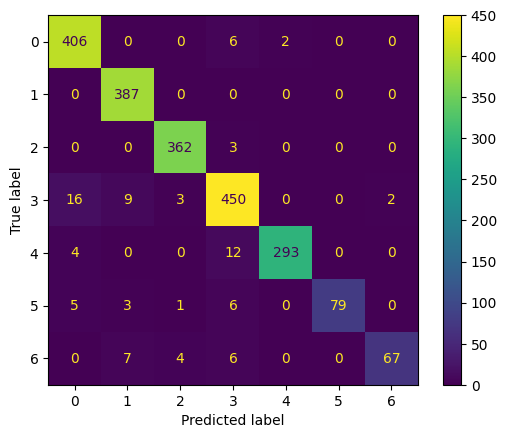

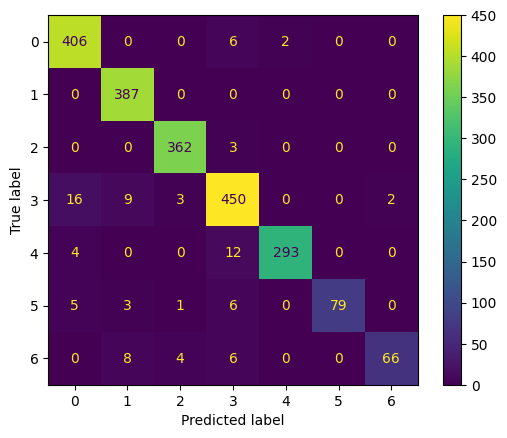

In [134]:
display_cm(y_test, y_pred)
display_cm(y_test, y_scaled_pred)

Clearly, scaling the data does not seem to help the Random Forest Classifier

## SVC (Support Vector Classifier)

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Hyperparameter search

In [22]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']} # Defining the hyperparameters to be tested

In [23]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=3) # Creating the GridSearchCV object
grid_search.fit(X_train_scaled, y_train) # Fitting the model
print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.593 total time=   3.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.594 total time=   3.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.610 total time=   3.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.602 total time=   3.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.601 total time=   3.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.788 total time=   2.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.801 total time=   2.6s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.809 total time=   2.5s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.779 total time=   2.4s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.791 total time=   2.4s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.550 total time=   3.4s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;

In [25]:
def fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.1, kernel='rbf'):
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred), y_pred

Model training

In [33]:
svc_model, svc_report, y_svc_pred = fit_SVC(X_train_scaled, X_test_scaled, y_train, y_test, C=100, gamma=0.01, kernel='rbf')
print(f"**Classification report (SVC):**\n{svc_report}")

svc_model_scaled, svc_report_scaled, y_svc_pred_scaled = fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.01, kernel='rbf')
print(f"**Classification report (SVC, scaled data):**\n{svc_report_scaled}")

**Classification report (SVC):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.94      0.94       414
       curva_direita_agressiva       0.97      1.00      0.98       387
      curva_esquerda_agressiva       0.99      0.98      0.99       365
          evento_nao_agressivo       0.91      0.94      0.92       480
              freada_agressiva       1.00      0.94      0.97       309
 troca_faixa_direita_agressiva       0.98      0.94      0.96        94
troca_faixa_esquerda_agressiva       0.91      0.85      0.88        84

                      accuracy                           0.96      2133
                     macro avg       0.96      0.94      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133

**Classification report (SVC, scaled data):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.89      0.90  

SVC works better with scaled data

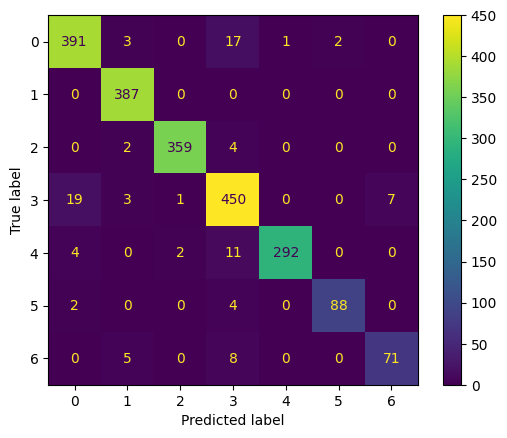

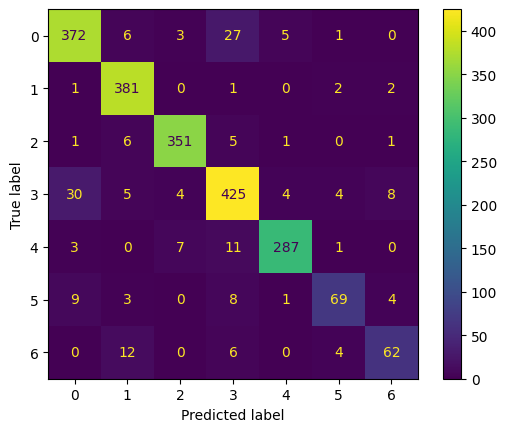

In [34]:
display_cm(y_test, y_svc_pred)
display_cm(y_test, y_svc_pred_scaled)

## XGBoost

In [49]:
from xgboost import XGBClassifier

In [47]:
def fit_XGB(X_train, X_test, y_train, y_test, n_estimators=200, max_depth=4):
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred), y_pred

One Hot Encoding so that the model works properly

In [51]:
classes = np.unique(y_train)
one_hot = {}
for i in range(len(classes)):
    one_hot[classes[i]] = i

{'aceleracao_agressiva': 0, 'curva_direita_agressiva': 1, 'curva_esquerda_agressiva': 2, 'evento_nao_agressivo': 3, 'freada_agressiva': 4, 'troca_faixa_direita_agressiva': 5, 'troca_faixa_esquerda_agressiva': 6}


In [52]:
y_train_one_hot = np.array([one_hot[i] for i in y_train])
y_test_one_hot = np.array([one_hot[i] for i in y_test])
y_train_one_hot, y_test_one_hot

(array([3, 0, 2, ..., 1, 2, 2]), array([2, 4, 0, ..., 5, 0, 3]))

In [62]:
xgb_model, xgb_report, y_pred_xgb = fit_XGB(X_train_scaled, X_test_scaled, y_train_one_hot, y_test_one_hot, n_estimators=100, max_depth=3)
print(f"**Classification report (XGB):**\n{xgb_report}")
print(f"**Classes:**\n")
for i in range(len(one_hot)):
    print(f"{i}: {classes[i]}")

**Classification report (XGB):**
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       414
           1       0.99      1.00      0.99       387
           2       0.99      1.00      1.00       365
           3       0.98      0.99      0.98       480
           4       1.00      0.98      0.99       309
           5       0.99      0.95      0.97        94
           6       0.99      0.92      0.95        84

    accuracy                           0.99      2133
   macro avg       0.99      0.97      0.98      2133
weighted avg       0.99      0.99      0.99      2133

**Classes:**

0: aceleracao_agressiva
1: curva_direita_agressiva
2: curva_esquerda_agressiva
3: evento_nao_agressivo
4: freada_agressiva
5: troca_faixa_direita_agressiva
6: troca_faixa_esquerda_agressiva


# MLP Scikit-Learn

In [63]:
from sklearn.neural_network import MLPClassifier

In [66]:
def fit_MLP(X_train, X_test, y_train, y_test, hidden_layer_sizes=(100, 50, 25), max_iter=1000, activation='relu', solver='adam'):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation=activation, solver=solver)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, classification_report(y_test, y_pred), y_pred

In [69]:
mlp, mlp_report, y_pred_mlp = fit_MLP(X_train_scaled, X_test_scaled, y_train, y_test, hidden_layer_sizes=(500, 250, 100, 50), max_iter=2000, activation='relu', solver='adam')
print(f"**Classification report (MLP):**\n{mlp_report}")

**Classification report (MLP):**
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.96      0.98      0.97       414
       curva_direita_agressiva       1.00      1.00      1.00       387
      curva_esquerda_agressiva       0.99      0.99      0.99       365
          evento_nao_agressivo       0.95      0.96      0.96       480
              freada_agressiva       1.00      0.99      0.99       309
 troca_faixa_direita_agressiva       0.97      0.90      0.93        94
troca_faixa_esquerda_agressiva       0.92      0.90      0.91        84

                      accuracy                           0.98      2133
                     macro avg       0.97      0.96      0.97      2133
                  weighted avg       0.98      0.98      0.98      2133



# MLP TensorFlow

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization

In [79]:
def resultados_modelo(historico):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()

    ax[0].plot(historico.history['accuracy'], label='Accuracy', marker='o', color='red')
    ax[0].plot(historico.history['val_accuracy'], label='Val_Accuracy', marker='o', color='blue')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(historico.history['loss'], label='Loss', marker='o', color='red')
    ax[1].plot(historico.history['val_loss'], label='Val_Loss', marker='o', color='blue')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    for i in range(2):
        ax[i].legend()
        ax[i].grid()

    acc_size =len(historico.history["accuracy"]) - 1
    print(f'Acurácia final: {round(100 * historico.history["accuracy"][acc_size], 3)}%')
    loss_size =len(historico.history["loss"]) - 1
    print(f'Loss final: {round(100 * historico.history["loss"][loss_size], 3)}%')

In [73]:
model =  Sequential([
    Dense(500, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    LayerNormalization(),
    Dense(250, activation='relu'),
    Dropout(0.2),
    LayerNormalization(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    LayerNormalization(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    LayerNormalization(),
    Dense(len(classes), activation='softmax')
])

In [76]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 500)            │        54,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 500)            │         1,000 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 250)            │           500 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 100)            │           200 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 50)             │           100 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,057 (828.35 KB)

 Trainable params: 212,057 (828.35 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
results = model.fit(X_train_scaled, y_train_one_hot, validation_data=(X_test_scaled, y_test_one_hot), epochs=25, batch_size=64, verbose=1)
resultados_modelo(results)

Epoch 1/25


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9966 - loss: 0.0100 - val_accuracy: 0.9808 - val_loss: 0.1234
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9789 - val_loss: 0.1236
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9827 - val_loss: 0.1022
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9775 - val_loss: 0.1320
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9803 - val_loss: 0.1031
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 0.9780 - val_loss: 0.1086
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9966 - loss: 0.0105 - val_accuracy: 0.9798 - val_loss: 0.1139
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9976 - loss: 0.0103 - val_accuracy: 0.9747 - v

In [88]:
y_pred_prob = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_prob, axis=1)
report_mlp = classification_report(y_test_one_hot, y_pred_nn)
print(f"**Classification report (MLP):**\n{report_mlp}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
**Classification report (MLP):**
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       414
           1       0.98      1.00      0.99       387
           2       1.00      1.00      1.00       365
           3       0.96      0.97      0.96       480
           4       0.99      0.98      0.99       309
           5       0.97      0.95      0.96        94
           6       0.95      0.93      0.94        84

    accuracy                           0.98      2133
   macro avg       0.98      0.97      0.97      2133
weighted avg       0.98      0.98      0.98      2133

